# dPFT (DDR-based Pulmonary Function Test) Tutorial

This tutorial is to preprocess a dicom file of DXR acquired images, and run SLEAP-based tracking

dPFT is built to work with mp4s. There are ways to convert from dicom or AVI to mp4. Depending on your data/DXR machine, there might be conversion issues between data type (dicom, avi, etc). Most versions of Konica Minolta software have the ability to output avis.

It is important to ensure there is sufficient contrast in the initial mp4 files, as conversions and improper data types can signficantly affect performance.

Some compensation for this can be done using the CLAHE preprocessing step below in our pipeline, but it is best to ensure no loss of resolution prior to using CLAHE.

Of note our data analysis was done using a Windows-based PC with a Nvidia GPU:
SLEAP: 1.2.1
TensorFlow: 2.6.3
Numpy: 1.19.5
Python: 3.7.12
OS: Windows-10-10.0.19041-SP0

SLEAP has capabilities for Macs as well. Our dPFT pipeline should work on Mac; however it has not been fully tested.

In [1]:
# imports, see INSTALLATION.md if you get any errors
from dPFT.dxr_inference import *

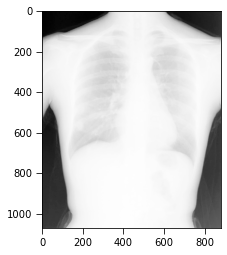

In [2]:
#location of data, for this example the dPFT github folder
#set your path here to the dPFT folder
dxr_fld = r'C:\Users\tpisano\Downloads\dPFT'#'/Users/tjp7rr1/Downloads/dPFT' #'E:/dPFT' 

# load the example image using imageio
arr = np.asarray(imageio.mimread(os.path.join(dxr_fld, 'data/1_PA_original.mp4'), memtest=False))[:,:,:,0] #grayscale image, only need one channel

#lets take a look at the image
plt.imshow(arr[10], cmap='Greys_r')

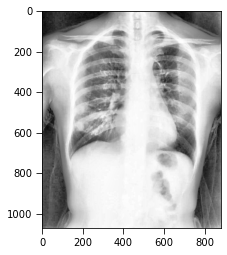

In [3]:
#You can see the lung but the contrast isn't great. Let's apply the CLAHE filter as a preprocessing step
mp4_clahe = os.path.join(dxr_fld, 'data/1_PA_clahe.mp4') #this is the output mp4 file after CLAHE preprocessing

# now apply filter and save
clahe = cv2.createCLAHE(clipLimit=8, tileGridSize=(10,10)) # clip limit and tilegridsizes emperically work well for PA images
narr = np.zeros_like(arr)
for i, img in enumerate(arr):
    narr[i] = clahe.apply(img)
imageio.mimwrite(mp4_clahe, np.asarray(narr), fps = 12, **{'macro_block_size':16})

#Again lets take a look and you'll see much improved contrast
plt.imshow(narr[10], cmap='Greys_r')

In [6]:
# now lets set up to run inference 
# you will need to make sure you have downloaded the CNNs for SLEAP processing (these are heavy)
# download: https://drive.google.com/drive/folders/19RFi1TA63rSfXhV1YV_W1SF-E4Ch2J5e?usp=drive_link

# unzip the file and place into single folder (dxr_trained_models)
# set path to this CNN folder
cnn_fld = 'Z:/dxr_trained_models' #'/Users/tjp7rr1/Downloads/dxr_trained_models/'

# Name of anaconda enviroment sleap is installed under, 
# this typically should be different than dPFT conda environment to ensure appropriate compartmentalization
enviroment_name = 'sleap' 

# order must be 'first_centroid' then 'second_centered' for each lung field
# if the folder containing the trained models was unzipped and unmodified then the appropriate paths below should work
models = {'left_diaphragm' : [os.path.join(cnn_fld, 'left_lower_lung_first_centroid'), os.path.join(cnn_fld, 'left_lower_lung_second_centered')],
          'right_diaphragm' : [os.path.join(cnn_fld, 'right_lower_lung_first_centroid'), os.path.join(cnn_fld, 'right_lower_lung_second_centered')],
          'lulungs': [os.path.join(cnn_fld, 'left_upper_lung_first_centroid'), os.path.join(cnn_fld, 'left_upper_lung_second_centered')],
          'rulung': [os.path.join(cnn_fld, 'right_upper_lung_first_centroid'), os.path.join(cnn_fld, 'right_upper_lung_second_centered')]}

#file to process - this should be a clahe mp4 file, in this case the processed file from above
# mp4_clahe = os.path.join(dxr_fld, 'data/1_PA_clahe.mp4')

# set destination and make nested folders
dst = os.path.join(dxr_fld, 'output')#'/Users/tjp7rr1/Downloads/dPFT_output'

# make the correct folders
makedir(dst); inference_dst = os.path.join(dst, 'inference')
csv_file = mp4_clahe.replace('clahe.mp4', '.predictions.analysis.h5.csv')
combineddfpth = os.path.join(inference_dst, 'combined_dataframe.csv')
makedir(dst); makedir(inference_dst)

##switches - adjust these based on desired output
convert_to_dataframe = True
batchsize = 1

#run inference. Depending on your machine, this can take some time
for modelnm, model in models.items():
    try:
        minffld = os.path.join(inference_dst, modelnm); makedir(minffld)
        #run inference and convert to analysis file
        input_pth = os.path.join(minffld, '{}.predictions.slp'.format(os.path.basename(mp4_clahe)))
        input_pth = SLEAP_inference(model, mp4_clahe, tracker=True, dst=minffld, enviroment_name=enviroment_name, batchsize=batchsize, givecall=True)
        SLEAP_convert(input_pth, mp4_clahe, outtype='analysis', enviroment_name=enviroment_name, batchsize=batchsize, givecall=True)
        if convert_to_dataframe: df = convert_to_pandas(filename = input_pth.replace('.slp', '.analysis.h5'), dst=minffld)
    except:
        print('Failed {}'.format(modelnm))

    #Combine outputs into single csv
    df = pd.concat([pd.read_csv(xx) for xx in listall(inference_dst, keyword='.csv')])
    #remove structures that were picked up by multiple nets
    df = df.drop_duplicates(subset=['frame', 'label_id'], keep='last') #df = df.sort_values(by=['frame','label_id'])
    #remove any columns with unnamed in it, this is important.
    df = df.loc[:,~df.columns.str.startswith('Unnamed')]

    df.to_csv(combineddfpth, index=False)

conda run -n sleap sleap-track --model Z:/dxr_public\left_lower_lung_first_centroid --model Z:/dxr_public\left_lower_lung_second_centered -o C:\Users\tpisano\Downloads\dPFT\output\inference\left_diaphragm/1_PA_clahe.mp4.predictions.slp --verbosity rich --batch_size 1 --tracking.tracker flow C:\Users\tpisano\Downloads\dPFT\data/1_PA_clahe.mp4
conda run -n sleap sleap-convert --format analysis --video C:\Users\tpisano\Downloads\dPFT\data/1_PA_clahe.mp4 C:\Users\tpisano\Downloads\dPFT\output\inference\left_diaphragm/1_PA_clahe.mp4.predictions.slp


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:243: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:211: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


conda run -n sleap sleap-track --model Z:/dxr_public\right_lower_lung_first_centroid --model Z:/dxr_public\right_lower_lung_second_centered -o C:\Users\tpisano\Downloads\dPFT\output\inference\right_diaphragm/1_PA_clahe.mp4.predictions.slp --verbosity rich --batch_size 1 --tracking.tracker flow C:\Users\tpisano\Downloads\dPFT\data/1_PA_clahe.mp4
conda run -n sleap sleap-convert --format analysis --video C:\Users\tpisano\Downloads\dPFT\data/1_PA_clahe.mp4 C:\Users\tpisano\Downloads\dPFT\output\inference\right_diaphragm/1_PA_clahe.mp4.predictions.slp
conda run -n sleap sleap-track --model Z:/dxr_public\left_upper_lung_first_centroid --model Z:/dxr_public\left_upper_lung_second_centered -o C:\Users\tpisano\Downloads\dPFT\output\inference\lulungs/1_PA_clahe.mp4.predictions.slp --verbosity rich --batch_size 1 --tracking.tracker flow C:\Users\tpisano\Downloads\dPFT\data/1_PA_clahe.mp4
conda run -n sleap sleap-convert --format analysis --video C:\Users\tpisano\Downloads\dPFT\data/1_PA_clahe.mp

## Working with dPFT output
Congratulations, you've made it through the hard part of installing SLEAP, and running the dPFT inference!

Now we can take a look at the output. We will generate nice overlays to better understand tracking performance and better understand new avenues of analysis now available.

In [7]:
# first set directory for location to save different forms of output
dst_to_save_videos = os.path.join(dst, 'tracking_output_analysis'); makedir(dst_to_save_videos)
fps=12

## Lets first make an 'ethogram' video. 
This is a video of the labeled dxr points overlayed on the original image on the left side, while we pick show several sample movement over time plots on right. 

In [8]:
#make ethogram video
ethogramylim = [-50, 50]
category_to_plot = 'distance_from_med' # distance_from_med'#'distance_from_med'#'distance_from_start' #'vel_rolling'#'velocity'#'ychange' #velocity, xchange, y
structures_to_include = ['L7', 'R7', 'AtAp LV', 'Lat LV', 'LL LV', 'L Cen D', 'R Cen D',]#'L4', 'L6', 'R4', 'R6' #'LC CW', 'RC CW','L Lat D', 'R Lat D','S AK', 'L AK', 'L Med D', 'R Med D', 'R LU D', 'R RU D', 'L LU D', 'L RU D', 'L7', 'R7','Lat RV','R Coracoid', 'L Coracoid', 'L SternClav', 'R SternClav', 'R Prox Clav', 'L Prox Clav', 'R Mid Clav', 'L Mid Clav', 'R Dist Clav', 'L Dist Clav'
subtract_value=0.0 #between 0 and 1, use for preprocessing
build_ethogram(mp4_clahe, csv_file=combineddfpth, structures_to_include=structures_to_include, category_to_plot=category_to_plot, dst = dst_to_save_videos, fps=fps)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1800, 1200) to (1808, 1200) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


### Go ahead and take a look at the video in the saved folder. We will also load a single frame below to get a feel for what we are creating

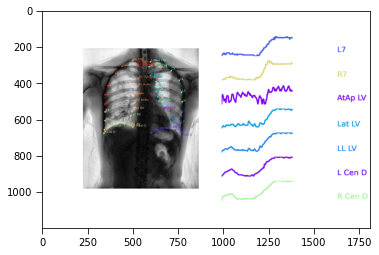

In [19]:
plt.imshow(imageio.mimread(os.path.join(dst_to_save_videos, 'ethogram.mp4'), memtest=False)[150], axis=False)

### Being able to track points is nice, but the real power comes from calculating lung areas by frame
this function generates a .csv file (_areas_and_curvature_indices.csv) containing different lung and sub-region areas by frame

In [22]:
# calculate area
areas = calculate_area(dfpth=combineddfpth)

### Now lets create lung areas and view as a video
this function also creates the _areas_and_curvature_indices csv file for analysis

In [23]:
structures_to_show = ['llung_lheart', 'rlung_rheart', 'heart']#, 'r_diaphragm_curvature_index', 'l_diaphragm_curvature_index'], 'total_lung'
areas = calculate_area_with_videos(dfpth=combineddfpth, vidpth=mp4_clahe, svfld=dst_to_save_videos, plot_areas=True, alpha=0.5, fps=fps, structures_to_show=structures_to_show)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1800, 1200) to (1808, 1200) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Again we'll plot one frame to get a feel for what we made, but go ahead and take a look at the area video now too.

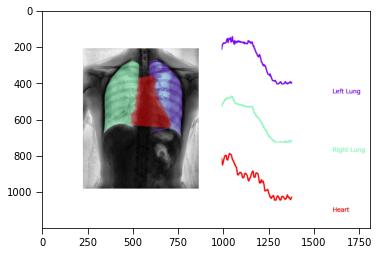

In [25]:
lung_areas_file = listdirfull(dst_to_save_videos, keyword='_areas.mp4')[0]
plt.imshow(imageio.mimread(lung_areas_file, memtest=False)[150])

### Diaphragm curvature index
Another thing of interest is to look at the changes in curvature of the diaphragm during respiration. This can be useful to compare patient with normal physiology with patients that have hyperinflated physiology like COPD. 

Note if the CNN fails on lung point tracking across several consecutive frames, this function will fail.

In [26]:
area_dfpth = listall(dst_to_save_videos, keyword='areas_and_curvature_indices')[0]
_=plot_curvature_index(dfpth=combineddfpth, area_dfpth=area_dfpth, vidpth=mp4_clahe, svfld=dst_to_save_videos, alpha=0.5, fps=fps)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1800, 1200) to (1808, 1200) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


### Again lets take a look at what we are creating, but go ahead and take a look at the curvature index video

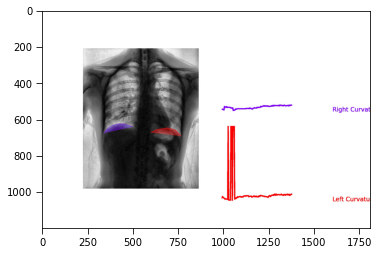

In [27]:
curvature_file = listdirfull(dst_to_save_videos, keyword='_curvature.mp4')[0]
plt.imshow(imageio.mimread(curvature_file, memtest=False)[150])

### Generate Strain Maps
Finally, it may be of use to visualize distance change maps, which is way to visualize strain.
We introduce the idea of strain for dPFTs, however a similar, essentially the same, idea is used in echocardiography routinely.


In [31]:
# this function calculates strain and makes a plot of strain ('_distance_changes.png'). 
# If you would like to make a video of this as well, keep 'generate_distance_change_maps_videos' set to true
generate_distance_change_maps_videos = True
make_distance_change_maps(svfld=dst_to_save_videos, dfpth=combineddfpth, vidpth=mp4_clahe, generate_distance_change_maps_videos=generate_distance_change_maps_videos, fps=fps)

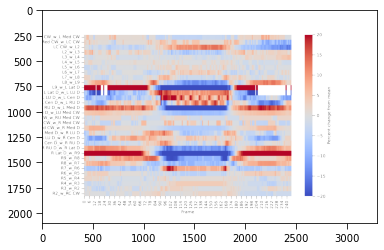

In [38]:
# plot the strain map
strain_map = listdirfull(dst_to_save_videos, keyword='_distance_changes.png')[0]
plt.imshow(imageio.imread(strain_map))

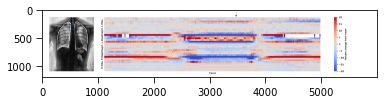

In [39]:
# Finally take a look at the strain video
strain_map_video = listdirfull(dst_to_save_videos, keyword='_distance_changes.mp4')[0]
plt.imshow(imageio.mimread(strain_map_video, memtest=False)[150])

# Now we can calculate PFT-like features during patients breathing cycle

First, we must calculate peaks and troughs using signal analysis. Peaks are the maximum lung area and can be thought of as maximum inspiration (or the point when expiration is about to begin). Troughs can be thought of as the opposite. That is the point of maximum expiration (or when inspiration is about to begin).

In [3]:
# first lets import some new functions
from dPFT.analysis_tools import *

In [5]:
# set paths to the appropriate folders/files
# This is the location of your dPFT folder, should be same as above
dxr_fld = r'C:\Users\tpisano\Downloads\dPFT'

# next set a path to the clahe_areas_and_curvature_indices.csv file that was generated from before
fl = os.path.join(dxr_fld, 'output/tracking_output_analysis/1_PA_clahe_areas_and_curvature_indices.csv')

# switches below 
# should not need to touch for this tutorial
# but sometimes it's nice to play around with this for your own dxrs
gaussigma = 3
alpha = 0.5
number_points_before_after=15
filetype= '.png' #'.pdf' produces better images but not as easy to read into jupyter notebook
cat_class = False 
area_type = 'total_lung' # between 'lungs-heart' and 'total_lung'
cm_to_pixel_conversion=.0016 #cm_to_pixel_conversion - this would be square cm^2 per pixel. E.g. 400um x 400um pixel = 0.0016

# folder set up
figdst = os.path.join(dxr_fld, 'output/figures'); makedir(figdst)
savedst = os.path.join(dxr_fld, 'output/peaks'); makedir(savedst)

# find peaks relative to other peaks
df = pd.read_csv(fl).sort_values('frame')
x,y=df[['frame', area_type]].values.T 
pntid = '1_PA'
find_peaks_relative_to_other_peaks(x,y, number_points_before_after=number_points_before_after, gaussigma=gaussigma, alpha=alpha, figdst=figdst, savedst=savedst, pntid=pntid, filetype=filetype, cat_class=cat_class, cm_to_pixel_conversion=cm_to_pixel_conversion, area_type=area_type)

## dPFT area by time plots, comparable to PFT volume by time plots
Now lets take a look at the plots (analysis csv files will be saved in the peaks folder)

This is showing lung area over time. This can be thought of similarly to what is done during traditional PFTs

On the left you can see equivalents for Total Lung Capacity (TLC), median Tidal volume (TV), Pulmonary Reserve %, Maximum 'tidal differences' and all tidal differences.

(-0.5, 1799.5, 1199.5, -0.5)

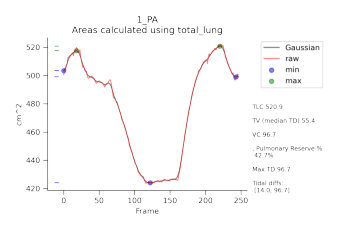

In [10]:
plt.imshow(imageio.imread(os.path.join(figdst, '1_PA.png'))); plt.axis('off')

## Flow by area loops

We can also take a look at the flow plots as well

The top graph is showing area over time, with color representing time. This is helpful when looking at the lower graph with ths same color scheme for time. 

The lower graph shows (pixel) flow by area ("flow-area loops"), which can be thought of as the equivalent to PFT-based flow-volume loops

(-0.5, 1799.5, 1199.5, -0.5)

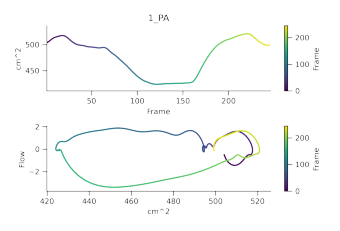

In [7]:
plt.imshow(imageio.imread(os.path.join(figdst, '1_PA_flow_plots.png'))); plt.axis('off')

## Calculate Trigger breaths
Triggered breaths, are starting time at zero at the intitiation of each inhalation and expiration. 
This is useful wehn studying different breaths (e.g. patient's maximumal intensity breath relative to their tidal breathing). If these two are close to each other, that would suggest little respiratory reserve.

In [8]:
#Now we can also generate breath triggered plots
gfl = os.path.join(savedst, '1_PA_original_data_w_gaussian_dataframe.csv')
pfl = os.path.join(savedst, '1_PA_peaks_dataframe.csv')
plot_triggered_breaths(peaksdf=pfl, areadf=fl, gausdf=gfl, figdst=figdst, pntid=pntid, filetype=filetype)

The top plot show triggered area plots. That is for each inhale (blue) and exhale (red) the area over time is shown. Similarly the bottom plot shows (pixel) flow over time for each breath.

(-0.5, 3599.5, 1799.5, -0.5)

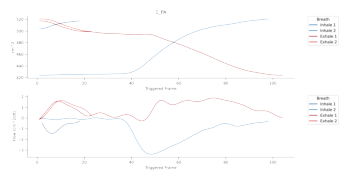

In [11]:
plt.imshow(imageio.imread(os.path.join(figdst, '1_PA_triggered_plots.png'))); plt.axis('off')